In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import pandas as pd
import seaborn as sns

In [2]:
import graphufs

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [3]:
plt.style.use("graphufs.plotstyle")

In [4]:
fig_dir = "figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
def swap_dims(xds):

    if "prediction_timedelta" in xds.coords and "lead_time" not in xds.coords:
        xds = xds.rename({"prediction_timedelta": "lead_time"})

    if "lead_time" in xds.dims:
        xds["fhr"] = (xds.lead_time.astype(int) / 3600 / 1e9).astype(int)
        xds = xds.swap_dims({"lead_time": "fhr"})
    return xds

In [6]:
def open_dataset(*args, **kwargs):
    xds = xr.open_dataset(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [7]:
def open_zarr(*args, **kwargs):
    xds = xr.open_zarr(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [10]:
models = [
    "GraphUFS",
    "GraphCast",
    "Pangu",
    #"ERA5 Forecasts",
    "IFS ENS Mean",
    "Replay", # bit of a misnomer
]

In [11]:
duration = "240h"
year = 2018

location = "/p1-evaluation/v1/validation"

spectra = {}

for model in models:
    name = model.lower().replace(" ", "_")
    middle = duration if model in ("GraphUFS", "Replay") else year
    spectra[model] = open_zarr(f"{location}/{name}.{middle}.spectra.zarr")

## Spectra

In [12]:
def get_save_kwargs(fhr, use_seaborn, show_diff, zoom):
    fname = f"{fig_dir}/spectra_surface_{fhr:03d}h"
    if zoom: 
        fname += "_zoom"
    if use_seaborn:
        fname += "_ci"
    if show_diff:
        fname + "_diff"
    fname += ".jpeg"
    return {"fname": fname, "bbox_inches": "tight", "dpi": 300}

In [13]:
def plot_spectra(
    mds,
    fhr,
    fields=("2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind"),
    use_seaborn=False,
    show_diff=False,
    zoom=False,
    save=False,
):
    ncols = len(fields)
    fig, axs = plt.subplots(1, ncols, figsize=(ncols*4, 4), constrained_layout=True)

    for i, (fld, ax) in enumerate(zip(fields, axs)):
        
        for j, (label, xds) in enumerate(mds.items()):
            kw = {
                "ax": ax,
                "x": "zonal_wavenumber",
                "color": f"C{j}" if label != "Replay" else "gray",
                "label": label if i == 0 else None,
                "linewidth": 2,
            }
            if (show_diff and label != "Replay") or not show_diff:
                if fld in xds:
                    plotme = xds[fld].sel(fhr=fhr)
                    if show_diff:
                        plotme = plotme - mds["Replay"][fld].sel(fhr=fhr)
                        plotme = np.abs(plotme)
                        plotme /= np.abs(mds["Replay"][fld].sel(fhr=fhr))
                    if use_seaborn:
                        sns.lineplot(
                            data=plotme.to_dataframe().reset_index(),
                            y=fld,
                            legend=False,
                            **kw,
                        )
                    else:
                        plotme.mean("latitude").plot(add_legend=False, **kw)
        title = " ".join([x.capitalize() if x != "of" else x for x in fld.replace("_", " ").split(" ")])
        zkw = {}
        if zoom:
            zkw = {"ylim": [None, 1e6], "xlim": [1e1, None]}
        else:
            if fld == "2m_temperature":
                zkw = {"ylim": [None, 1e9]}
        ax.set(
            xlabel="Zonal Wavenumber",
            ylabel="",
            title=title,
            xscale="log",
            yscale="log",
            **zkw,
        )
        for key in ["right", "top"]:
            ax.spines[key].set_visible(False)

    fig.legend(title=f"Lead Time = {fhr} hours", loc="center left", bbox_to_anchor=(1, .5))
    if save:
        fig.savefig(**get_save_kwargs(fhr=fhr, use_seaborn=use_seaborn, show_diff=show_diff, zoom=zoom))
    return fig, axs

In [15]:
kw = {
    "show_diff": False,
    "use_seaborn": False,
    "zoom": False,
    "save": True,
}

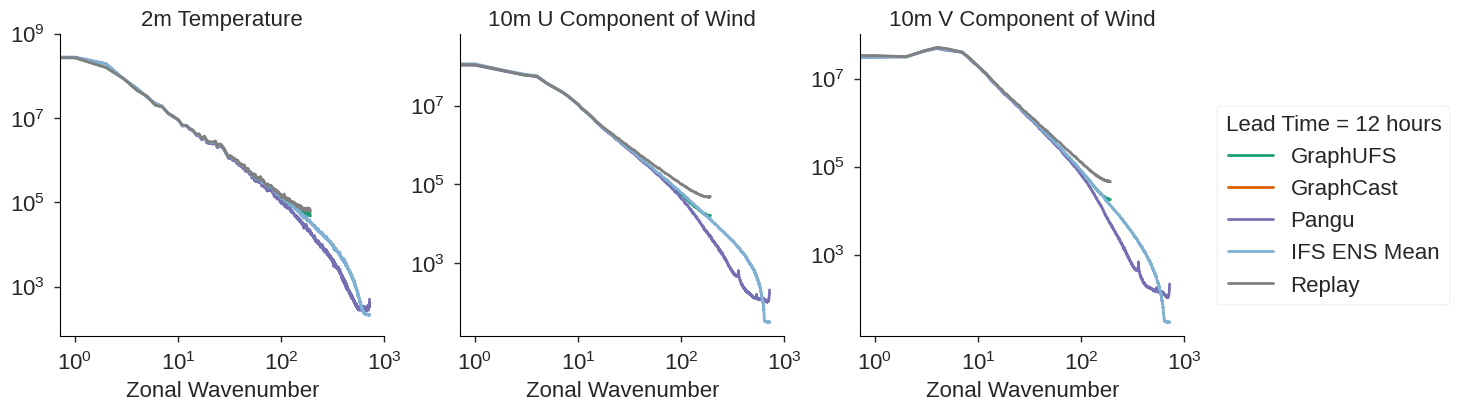

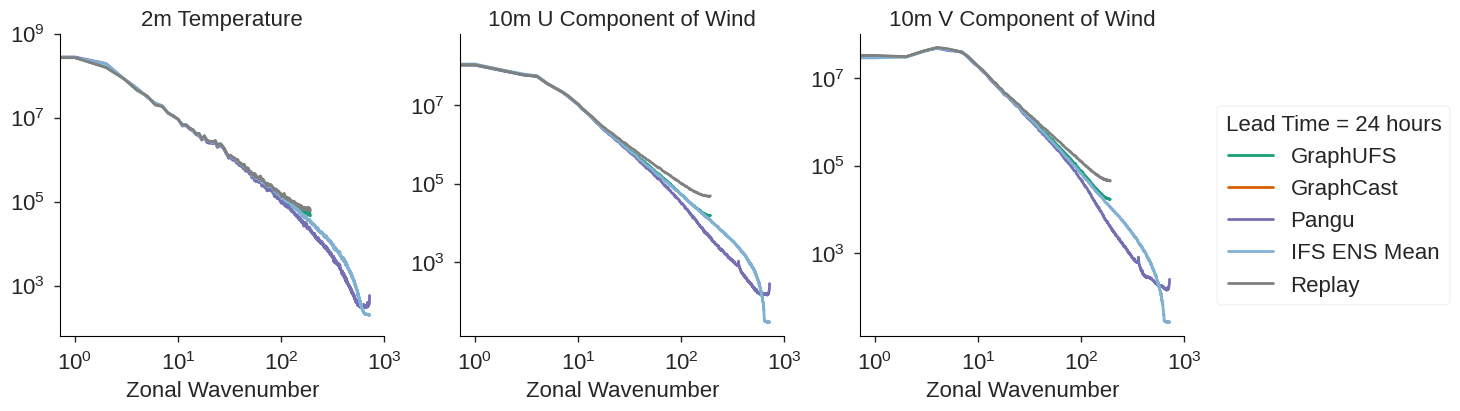

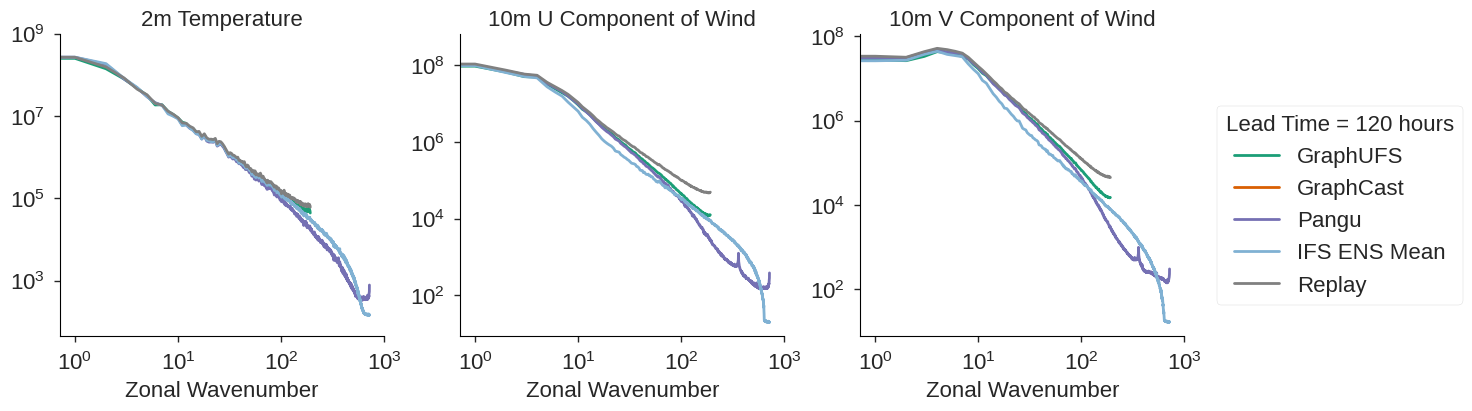

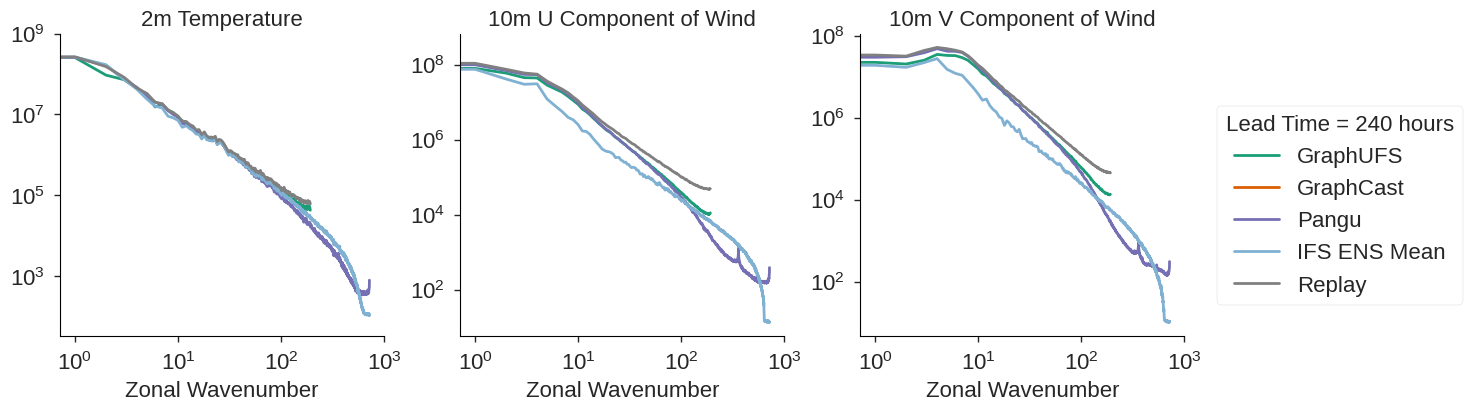

In [16]:
for fhr in [12, 24, 120, 240]:
    fig, axs = plot_spectra(spectra, fhr=fhr, **kw)

In [17]:
kw["zoom"] = True

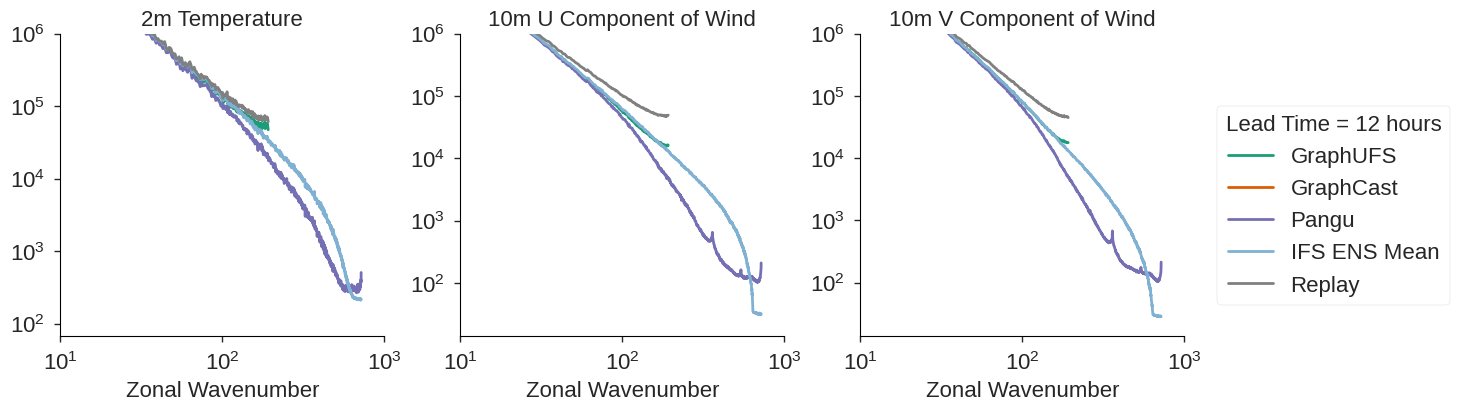

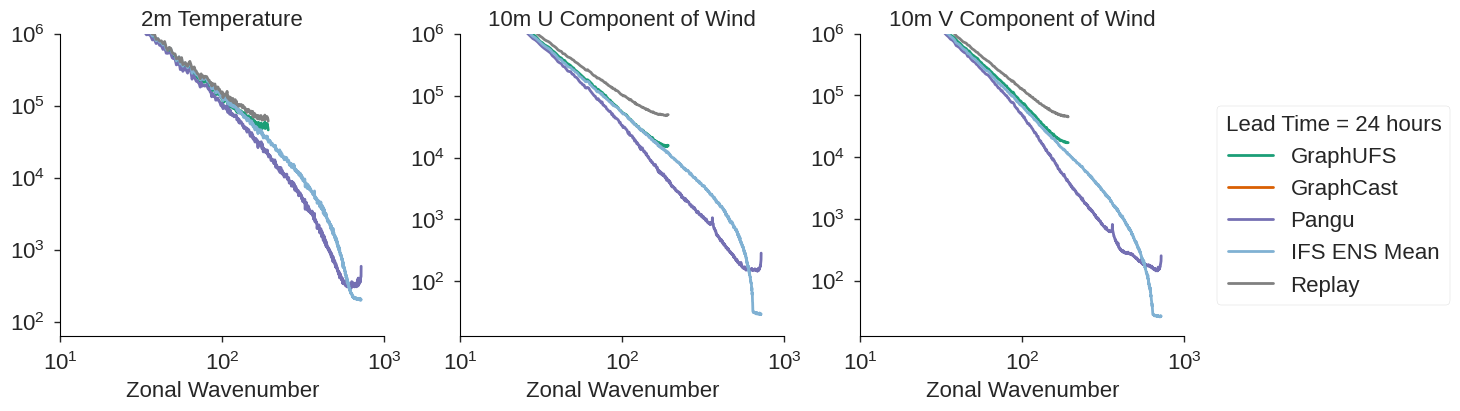

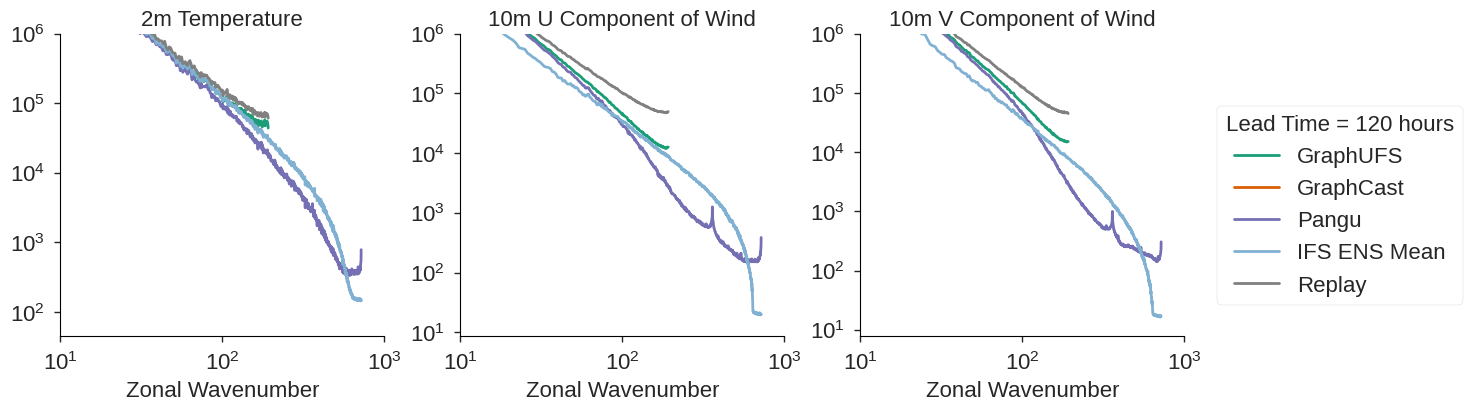

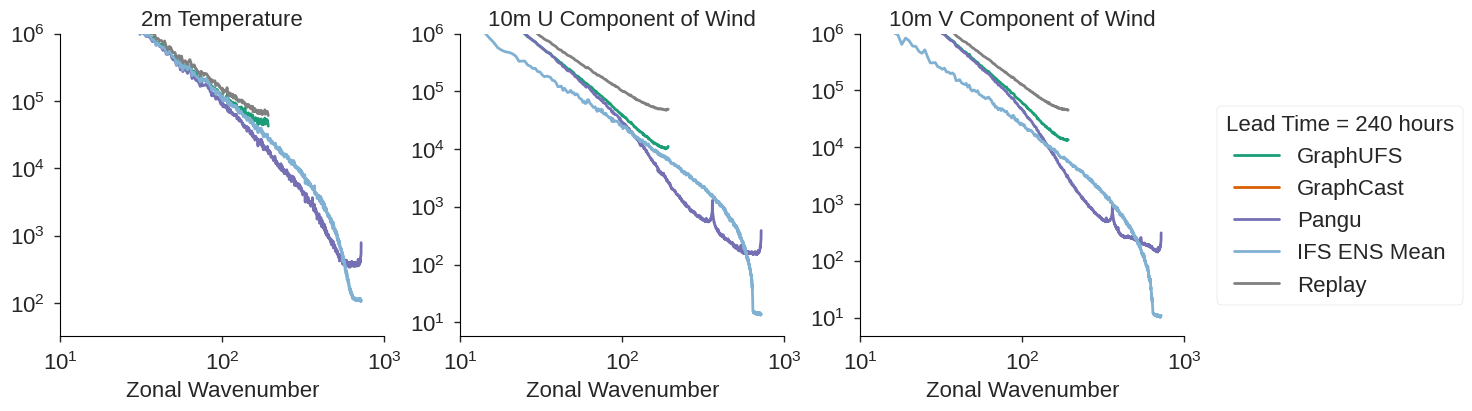

In [18]:
for fhr in [12, 24, 120, 240]:
    fig, axs = plot_spectra(spectra, fhr=fhr, **kw)